In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML

import torch
from torch.utils.data import Dataset, dataloader
import torch.nn.functional as F
from torchsummary import summary

import sys
sys.path.append('../src')
from model import *
from Animation import AnimatedScatter, AnimatedScatter_GradientData
from datagen import DataGen

c:\Users\kingt\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data generation

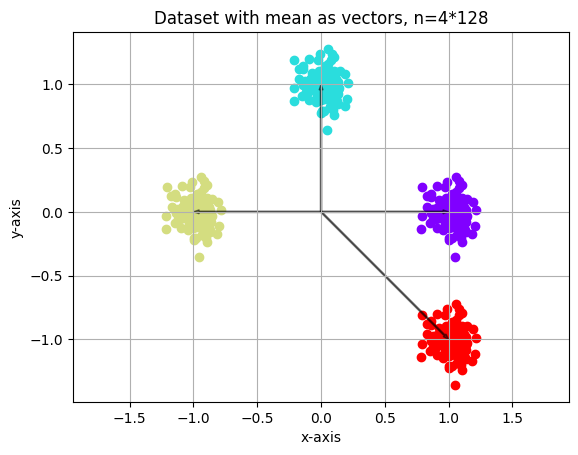

In [2]:
n_categories = 4
n_p = 128 # points_per_category


# sym, as, as_extra, parallel, manual
datatype = "as"
as_pos = np.array([1,-1])
noise = False
dataclass = DataGen(n_categories, n_p, scale=1, name=datatype, seed=1234, as_pos=as_pos,noise=noise)
centers,data,labels = dataclass.centers,dataclass.data,dataclass.labels

dataclass.plot()

if noise:
    n_categories += 1

# centers,data,labels = data_gen(n_categories,n_p,scale=1)
# centers,data,labels = data_gen_as_extra(n_categories,n_p,scale=1)

### Putting data in PyTorch dataset

In [3]:
class ScatterData(Dataset):
    def __init__(self,points,labels,n_cat):
        self.x = torch.tensor(points).float()
        self.y = torch.tensor(labels).to(int)
        self.y = F.one_hot(self.y, num_classes=n_cat).double()
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix): 
        return self.x[ix], self.y[ix]

In [4]:
BATCH_SIZE = 32

training_data = ScatterData(data,labels,n_categories)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

### Create model

### Training

In [5]:
# model = UMI_L1(2,n_categories,lr=1e-3)
# model = UMI(2,n_categories,lr=0.01,bias=False)


# model = UMI_J2(2,n_categories,lr=0.01,bias=False,decay=0.01)
# model = UMI_SVB_soft(2,n_categories,lr=0.001,bias=False,decay=0.01)

# summary(model,input_size=(1,2))

In [6]:
# model = UMI_Jacobi_abs(2,n_categories,lr=0.001,bias=False,decay=0.01,orthogonal=False)
# epoch_data, loss_data, crossloss_data, jacobiloss_data, area_data, area_data_mD = model.train(training_loader,n_epochs=500,area=True)

In [19]:
model = UMI_Jacobi_2_savegrad(2,n_categories,lr=0.001,bias=False,decay=1,orthogonal=False)
epoch_data, loss_data, crossloss_data, jacobiloss_data, area_data_mD, jacobigrad_data, crossgrad_data = model.train(training_loader,n_epochs=500,area=False)

16it [00:00, 239.44it/s]00:00<?, ?it/s]
16it [00:00, 291.69it/s]
16it [00:00, 302.69it/s]00:00<00:32, 15.31it/s]
16it [00:00, 305.52it/s]
16it [00:00, 276.60it/s]00:00<00:29, 16.61it/s]
16it [00:00, 254.65it/s]
16it [00:00, 237.64it/s]00:00<00:31, 15.93it/s]
16it [00:00, 213.90it/s]
16it [00:00, 163.70it/s]00:00<00:33, 14.75it/s]
16it [00:00, 276.60it/s]
16it [00:00, 258.76it/s][00:00<00:35, 13.69it/s]
16it [00:00, 267.38it/s]
16it [00:00, 267.38it/s][00:00<00:34, 14.27it/s]
16it [00:00, 314.57it/s]
16it [00:00, 308.52it/s][00:00<00:32, 15.02it/s]
16it [00:00, 283.92it/s]
16it [00:00, 291.69it/s][00:01<00:30, 15.62it/s]
16it [00:00, 254.65it/s]
16it [00:00, 269.59it/s][00:01<00:30, 15.71it/s]
16it [00:00, 267.38it/s]
16it [00:00, 302.69it/s][00:01<00:30, 15.72it/s]
16it [00:00, 193.28it/s]
16it [00:00, 263.00it/s][00:01<00:31, 15.09it/s]
16it [00:00, 262.99it/s]
16it [00:00, 248.70it/s][00:01<00:31, 14.95it/s]
16it [00:00, 243.07it/s]
16it [00:00, 243.07it/s][00:01<00:32, 14.77it/s]
16

In [15]:
# epoch_data, loss_data, area_data, area_data_mD = model.train(training_loader,n_epochs=500,area=True)
# epoch_data, loss_data, crossloss_data, jacobiloss_data, area_data, area_data_mD = model.train(training_loader,n_epochs=500)

# epoch_data, loss_data, crossloss_data, jacobiloss_data = model.train(training_loader,n_epochs=500)
# epoch_data, loss_data = model.train(training_loader,n_epochs=500)

### Training results visualization

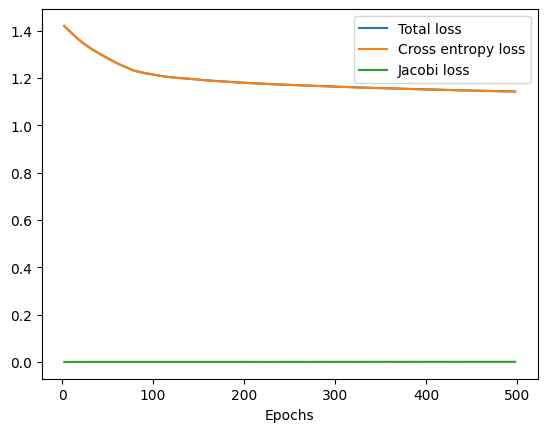

In [20]:
epoch_data_avgd = epoch_data.reshape(100,-1).mean(axis=1) # the number in reshape has to divide the number of epochs
loss_data_avgd = loss_data.reshape(100,-1).mean(axis=1)

plt.plot(epoch_data_avgd,loss_data_avgd, label="Total loss") # Plot the average loss per epoch

crossloss_data_avgd = crossloss_data[:].reshape(100,-1).mean(axis=1)
jacobiloss_data_avgd = jacobiloss_data[:].reshape(100,-1).mean(axis=1)
plt.plot(epoch_data_avgd,crossloss_data_avgd,label="Cross entropy loss") # Plot the average loss per epoch
plt.plot(epoch_data_avgd,jacobiloss_data_avgd, label="Jacobi loss") # Plot the average loss per epoch

# plt.title("Jacobi, 0.01LR, 10decay, 500 epochs, 66% acc")
# plt.plot(epoch_data,area_data, label="Weight Area")
# plt.plot(epoch_data,area_data_mD, label="Weight Area multiD")
plt.xlabel("Epochs")

# plt.plot(epoch_data,loss_data)
plt.legend()
plt.show()

### Testing

In [21]:
# t_centers, test_data, test_labels = data_gen_as_extra(n_categories,512)

test_n = 512

if noise:
    n_categories += -1

# n_categories = 2

test_data = DataGen(n_categories, test_n, scale=1, name=datatype, seed=3141, as_pos=as_pos)
t_centers, test_data, test_labels = test_data.centers,test_data.data,test_data.labels
test_set = ScatterData(test_data,test_labels,n_categories)

acc = (model(test_set.x).argmax(dim=1) == test_set.y.argmax(dim=1)).float().sum().item()/len(test_set)
print(f'Accuracy: {acc:.2f}')

Accuracy: 0.73


### Weights

[Parameter containing:
tensor([[ 0.3057, -0.2021],
        [-0.4102,  1.2879],
        [-0.5492,  0.2987],
        [ 0.6870, -1.5105]], requires_grad=True)]
-0.0058671045
-0.023144893
-0.049721554
-0.0076055317


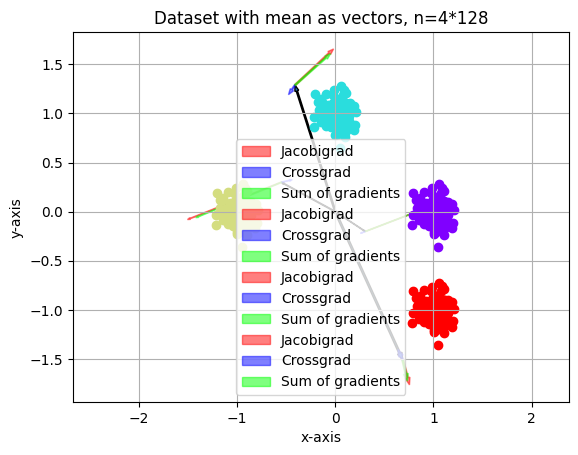

In [25]:
w = []

for param in model.parameters():
    w.append(param)
    print(w)

w_np = w[0].detach().numpy()
if len(w) > 1:
    bias = w[1].detach().numpy()



for i in range(len(w_np)):
    w_len = np.linalg.norm(w_np[i])
    width = 0.01*w_len
    # Weight arrows
    plt.arrow(0,0,w_np[i][0],w_np[i][1],length_includes_head=True,width=width)
    # Gradient arrows
    scale = 1
    plt.arrow(w_np[i][0],w_np[i][1],scale*jacobigrad_data[-1][i][0],scale*jacobigrad_data[-1][i][1],length_includes_head=False,width=width,color=(1,0,0,0.5),label="Jacobigrad")
    plt.arrow(w_np[i][0],w_np[i][1],scale*crossgrad_data[-1][i][0],scale*crossgrad_data[-1][i][1],length_includes_head=False,width=width,color=(0,0,1,0.5),label="Crossgrad")
    # Sum of gradients
    plt.arrow(w_np[i][0],w_np[i][1],scale*(jacobigrad_data[-1][i][0]+crossgrad_data[-1][i][0]),scale*(jacobigrad_data[-1][i][1]+crossgrad_data[-1][i][1]),length_includes_head=False,width=width,color=(0,1,0,0.5),label="Sum of gradients")
    print(jacobigrad_data[-10][i]@crossgrad_data[-10][i])

colors = cm.rainbow(np.linspace(0,1,n_categories))

plt.legend()
dataclass.plot(arrows=False)
# for col,center,i in zip(colors,centers,range(n_categories)):
#     plt.scatter(data[i*n_p:(i+1)*n_p,0],data[i*n_p:(i+1)*n_p,1],color=col)
#     # plt.arrow(0,0,center[0],center[1],length_includes_head=True,width=0.01,color=(0,0,0,0.5))



# plt.grid()
# plt.axis('equal')

(500, 2, 4)


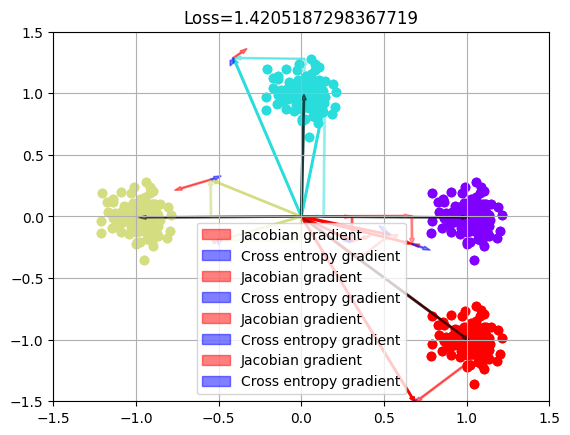

In [24]:
w_his = model.w_his
loss_data[::16].shape
w_his = np.array(w_his)
print(w_his.transpose([0,2,1]).shape)
# print(jacobigrad_data.transpose([0,2,1])[::16].shape)
w_his = np.array(w_his)

# animated_scatter = AnimatedScatter(data,w_his.transpose([0,2,1]),loss_data,n_clusters=n_categories,acc=acc)
animated_scatter = AnimatedScatter_GradientData(data,w_his.transpose([0,2,1]),jacobigrad_data.transpose([0,2,1])[::16],crossgrad_data.transpose([0,2,1])[::16],loss_data,n_clusters=n_categories,acc=acc)
html_object = HTML(animated_scatter.animation.to_html5_video())
html_object